## Estimating Home Value

by David Rodriguez 2021/12/13

#### Project Goal

The goal of this project is to predict assessed home values by the respective tax authority as accurately as possible based on a zillow dataset of home listings from 2017.

#### Project Description

Home value appraisals are a big factor in deciding which home to live in. A property's assessed tax value can be contested, but generally falls in a range assessed. That assessed value coult ultimately be a big factor on whether or not a prospective buyer purchases a home. Naturally, property taxes can be a big liability for homeowners and therefore it is an important factor that must be taken into account. Based on data from home listings from 2017, the goal of this exercise is to form a model to predict assessed home values.

#### Initial Questions

1. Given the information we have, what is the biggest factor of assessed taxes in homes?
2. Does the location of the home matter?
3. Is the total square feet of a home relevant at all in predicting assessed value?
4. Does the number of bedrooms or bathrooms relevant?

#### Data Dictionary

| Variable | Description |                           |
|:-------------------|:--------------------------------|:
| 1. bedroom_cnt | Number of bedrooms in each home. | 
| 2. bathroom_cnt | Number of bathrooms in each home. Can be half bathrooms and there will not be rows with 0 bathrooms |
| 3. pool_cnt | Number of pools in each home. |
| 4. nbr_stories | Number of stories in each home. |
| 5. assessed_tax_value | The target variable. Assessed property tax value of each home. |
| 6. year_built | The year the home was built. |
| 7. fips | Coding used to identify the county in which the home is located in. |
| 8. comb_sq_ft | An amalgamation of three different columns from the Zillow database. This column is a sum of columns: basementsqft, garagetotalsqft, and calculatedfinishedsquarefeet. |
| 9. location | A mapped fips column reflecting the name of the county of the fips code represents. |

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.feature_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import env
import wrangle

In [2]:
# Acquire the dataset
df = wrangle.zillow_data()
df.head()

,bedroomcnt,bathroomcnt,basementsqft,garagetotalsqft,calculatedfinishedsquarefeet,poolcnt,numberofstories,taxvaluedollarcnt,yearbuilt,fips
0,4.0,3.5,NaN,633.0,3100.0,NaN,NaN,1023282.0,1998.0,6059.0
1,2.0,1.0,NaN,0.0,1465.0,NaN,1.0,464000.0,1967.0,6111.0
2,3.0,2.0,NaN,440.0,1243.0,1.0,1.0,564778.0,1962.0,6059.0
3,4.0,3.0,NaN,NaN,2376.0,1.0,NaN,145143.0,1970.0,6037.0
4,4.0,3.0,NaN,NaN,2962.0,1.0,NaN,773303.0,1950.0,6037.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   basementsqft                  47 non-null     float64
 3   garagetotalsqft               18015 non-null  float64
 4   calculatedfinishedsquarefeet  52359 non-null  float64
 5   poolcnt                       11096 non-null  float64
 6   numberofstories               14561 non-null  float64
 7   taxvaluedollarcnt             52440 non-null  float64
 8   yearbuilt                     52325 non-null  float64
 9   fips                          52441 non-null  float64
dtypes: float64(10)
memory usage: 4.0 MB


In [4]:
# clean up the data

df = wrangle.wrangle_zillow(df)
df.isnull().sum()

# the wrangle data function cleans up missing values and fills 0's/1's where applicable.
# furthermore, outliers are also removed and homes with 0 bathrooms and combined square feet
# less than 200 are removed
    # the thinking on the last two points is that is unlikely for there to be homes w/o 
    # bathrooms and homes with 200 or less total square feet do not seem feasible to live in
# finally the wrangel function maps the fips code to the respective county.

bedroom_cnt           0
bathroom_cnt          0
pool_cnt              0
nbr_stories           0
assessed_tax_value    0
year_built            0
fips                  0
comb_sq_ft            0
location              0
dtype: int64

In [ ]:
df.info()

In [ ]:
for col in df:
    sns.displot(x = col, data = df, hue = 'location')
    plt.title(col + ' distribution')
    plt.show()

In [ ]:
# some quick takeaways from univariate visualization include: 
    # most houses have 3 to 4 bedrooms
    # most houses have between 2 and 3 bathrooms
    # most houses do not have a pool and are one story homes

In [54]:
train, validate, test = wrangle.encode_split(df)
train.shape, validate.shape, test.shape

((28332, 11), (12593, 11), (9445, 11))

In [ ]:
for col in df:
    sns.lineplot(x = col, y = df['assessed_tax_value'], data = df, hue = 'location')
    plt.title(col + ' lineplot')
    plt.show()

In [ ]:
# Some more takeaways:
    # there seems to be correlation between the number of bedrooms, bathrooms, and combined
    # square foot

In [ ]:
# Let's apply some statistics to corroborate our takeaways:
    # Bedroom count follows a somewhat normal distribution so let's try a pearsonr 
    # correlation:

In [ ]:
r, p_value = pearsonr(train.assessed_tax_value, train.bedroom_cnt)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

In [ ]:
# let's go ahead and do a correlation heatmap for the other features:
plt.figure(figsize = (8,8))
sns.heatmap(train.corr(method = 'spearman')[['assessed_tax_value']].sort_values(by = 'assessed_tax_value', ascending = False), square = False, annot = True, linewidth = 0.75)

In [ ]:
# As we can see, the features that correlate with our target are combined square feet,
# bathroom count, and to a lesster degree, bedroom count, year built, and pool count.
# since our correlation coefficient is greater than zero in the majority of the features,
# those can be safe to implement into modeling. As we move on to modeling, let's
# further analyze the best features using RFE when we start implementing regression
# methodologies.
# However, let's do an additional statistical test to check if location has an impact on
# appraised values:

In [ ]:
df.fips.value_counts()

In [ ]:
la_assessed_value = train[df.fips == 6037.0].assessed_tax_value
o_assessed_value = train[df.fips == 6059.0].assessed_tax_value
v_assessed_value = train[df.fips == 6111.0].assessed_tax_value

In [ ]:
la_assessed_value.hist();

In [ ]:
o_assessed_value.hist();

In [ ]:
v_assessed_value.hist();

In [ ]:
# verify assumptions
    # independent samples - yes
    # normal distribution - kinda
    # equal variances:
print(la_assessed_value.var())
print(o_assessed_value.var())
print(v_assessed_value.var())
        # no equal variances so let's do a two sample test instead of anova

Set Hypothesis

H0: Average assessed home value is the same for each county.

Ha: Average assessed home value is not the same for each county.

In [ ]:
print(f'Mean appraised value for Los Angeles County: ${la_assessed_value.mean():.2f}')
print(f'Mean appraised value for Orange County: ${o_assessed_value.mean():.2f}')
print(f'Mean appraised value for Ventura County: ${v_assessed_value.mean():.2f}')

In [ ]:
stat, p = stats.mannwhitneyu(la_assessed_value, o_assessed_value, alternative = 'two-sided')
print(f'Mann-Whitney results for Los Angeles and Orange counties:\nTest Statistic: {stat:.2f}\nP-Value: {p:.2f}')

In [ ]:
stat, p = stats.mannwhitneyu(la_assessed_value, v_assessed_value, alternative = 'two-sided')
print(f'Mann-Whitney results for Los Angeles and Ventura counties:\nTest Statistic: {stat:.2f}\nP-Value: {p:.2f}')

In [ ]:
stat, p = stats.mannwhitneyu(o_assessed_value, v_assessed_value, alternative = 'two-sided')
print(f'Mann-Whitney results for Orange and Ventura counties:\nTest Statistic: {stat:.2f}\nP-Value: {p:.2f}')

In [ ]:
# takeaways:
    # since all three p-values generated are less than the set alpha value of 0.05, we can 
    # reject the null hypothesis that average assessed home is the same among the three 
    # counties.

In [6]:
#Modeling
# baseline
baseline = wrangle.zillow_data()
baseline = wrangle.wrangle_zillow(baseline)
baseline['pred_mean'] = baseline.assessed_tax_value.mean()
baseline['pred_median'] = baseline.assessed_tax_value.median()

In [7]:
# split baseline dataset into train, validate, test
b_train_and_validate, b_test = train_test_split(baseline, random_state = 123)
b_train, b_validate = train_test_split(b_train_and_validate)

target = "assessed_tax_value"

# split train into X (dataframe, drop target) & y (series, keep target only)
b_X_train = b_train.drop(columns = [target])
b_y_train = b_train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
b_X_validate = b_validate.drop(columns = [target])
b_y_validate = b_validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
b_X_test = b_test.drop(columns = [target])
b_y_test = b_test[target]

In [8]:
# convert y train and validate into dataframes
b_y_train = pd.DataFrame(b_y_train)
b_y_validate = pd.DataFrame(b_y_validate)

# 1. calculate mean
b_pred_mean = b_y_train['assessed_tax_value'].mean()
b_y_train['pred_mean'] = b_pred_mean
b_y_validate['pred_mean'] = b_pred_mean

# 2. calculate median
b_pred_median = b_y_train['assessed_tax_value'].median()
b_y_train['pred_median'] = b_pred_median
b_y_validate['pred_median'] = b_pred_median

# 3. RMSE of mean
rmse_train = mean_squared_error(b_y_train.assessed_tax_value, b_y_train.pred_mean)**(1/2)
rmse_validate = mean_squared_error(b_y_validate.assessed_tax_value, b_y_validate.pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of median
rmse_train = mean_squared_error(b_y_train.assessed_tax_value, b_y_train.pred_median)**(1/2)
rmse_validate = mean_squared_error(b_y_validate.assessed_tax_value, b_y_validate.pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  387000.9 
Validate/Out-of-Sample:  386660.3
RMSE using Median
Train/In-Sample:  397489.54 
Validate/Out-of-Sample:  397760.19


In [61]:
# regression
# feature selection
train_scaled, validate_scaled, test_scaled = wrangle.standard_scaler_tvt(train, validate, test)

In [62]:
target = "assessed_tax_value"

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train_scaled = train_scaled.drop(columns = [target])
y_train = train[target]
y_train_scaled = train_scaled[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate_scaled = validate_scaled.drop(columns = [target])
y_validate = validate[target]
y_validate_scaled = validate_scaled[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test_scaled = test_scaled.drop(columns = [target])
y_test = test[target]
y_test_validate = test_scaled[target]

In [63]:
lrm = LinearRegression()
rfe = RFE(lrm, n_features_to_select = 1)

rfe.fit(X_train_scaled, y_train_scaled)

rfe_columns = X_train_scaled.columns[rfe.support_].tolist()
print('The best feature is: ', rfe_columns)

The best feature is:  ['comb_sq_ft']


In [64]:
ranks = wrangle.show_features_rankings(X_train_scaled, rfe)
ranks

,Var,Rank
6,comb_sq_ft,1
1,bathroom_cnt,2
0,bedroom_cnt,3
4,year_built,4
3,nbr_stories,5
5,fips,6
2,pool_cnt,7


In [59]:
# after going through removing the least effective features, I noticed that the model
# performed better if the features weren't removed.

In [72]:
# OLS

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

ols = LinearRegression(normalize = True)

ols.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_ols'] = ols.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_ols)**(1/2)

# predict validate
y_validate['pred_ols'] = ols.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_ols)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  315917.037821533 
Validation/Out-of-Sample:  319015.3594351313


In [73]:
# lassolars

lasso = LassoLars(alpha = 1.0)

lasso.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_lasso'] = lasso.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_lasso)**(1/2)

y_validate['pred_lasso'] = lasso.predict(X_validate_scaled)

rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_lasso)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  315917.57175075053 
Validation/Out-of-Sample:  319013.56465494237


In [82]:
# polynomial

pf = PolynomialFeatures(degree = 2)

X_train_degree2 = pf.fit_transform(X_train_scaled)

X_validate_degree2 = pf.transform(X_validate_scaled)

X_test_degree2 = pf.transform(X_test_scaled)

lm2 = LinearRegression(normalize = True)

lm2.fit(X_train_degree2, y_train.assessed_tax_value)

y_train['pred_lm2'] = lm2.predict(X_train_degree2)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_lm2)**(1/2)

y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  311285.7081004249 
Validation/Out-of-Sample:  315254.6820619175


In [ ]:
# the best performing model is the polynomial model. let's go ahead and apply it to the test
# dataset.

In [83]:
y_test = pd.DataFrame(y_test)

pf = PolynomialFeatures(degree = 2)

lm2 = LinearRegression(normalize = True)

lm2.fit(X_test_degree2, y_test.assessed_tax_value)

y_test['pred_lm2'] = lm2.predict(X_test_degree2)

rmse_test = mean_squared_error(y_test.assessed_tax_value, y_test.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTest Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Test Sample:  308440.1255669655


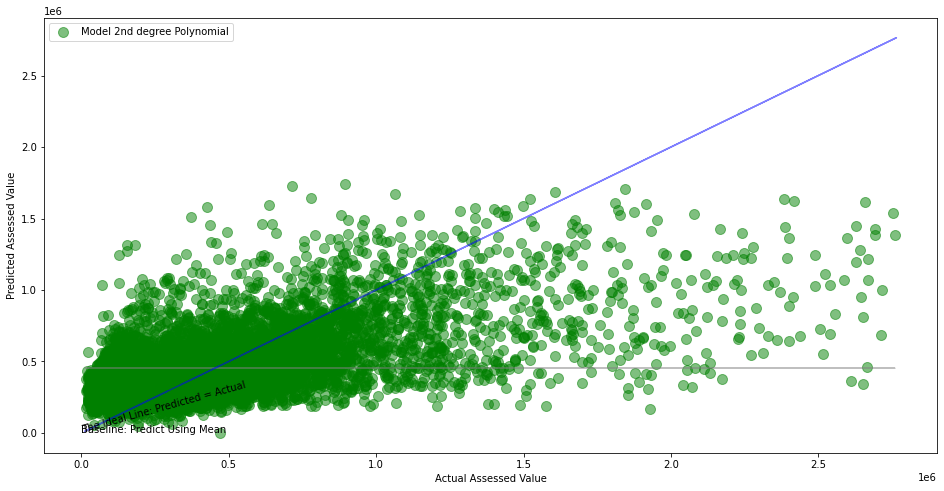

In [86]:
plt.figure(figsize = (16,8))
plt.plot(b_y_validate.assessed_tax_value, b_y_validate.pred_mean, alpha = .5, color = "gray", label = '_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.assessed_tax_value, y_validate.assessed_tax_value, alpha = .5, color = "blue", label = '_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation = 15.5)

#plt.scatter(y_validate.assessed_tax_value, y_validate.G3_pred_lm, 
#            alpha = .5, color = "red", s = 100, label = "Model: LinearRegression")
#plt.scatter(y_validate.assessed_tax_value, y_validate.G3_pred_glm, 
#            alpha = .5, color = "yellow", s = 100, label = "Model: TweedieRegressor")
plt.scatter(y_test.assessed_tax_value, y_test.pred_lm2, 
            alpha = .5, color = "green", s = 100, label = "Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Assessed Value")
plt.ylabel("Predicted Assessed Value")
#plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

In [ ]:
# Conclusion & Recommendations
    #